In [1]:
using LinearAlgebra, Plots, DelimitedFiles
include("hamming.jl")
include("chase.jl")
import .hamming, .chase

In [2]:
G, H = hamming.create_GH(9)
k, n = size(G)
batch_size = 100
min_num = 30
iter_num = 6
window_size = 7
Α = [0.0, 0.2, 0.3, 0.5, 0.7, 0.9, 1.0, 1.0]
h = chase.compute_h(H)
h_inv = chase.compute_h_inv(H)

1024-element Vector{Int64}:
 503
 504
   0
 505
   0
   0
 439
 506
   0
   0
   ⋮
  57
   0
   0
 438
   0
 374
 247
   0
   0

In [3]:
function error_rate(σ)
    ttt = 0
    A = zeros(Int64, batch_size + 12, Int64(n / 2), Int64(n / 2))
    for i = 2:size(A)[1]
        m = rand((0, 1), Int64(n / 2), k - Int64(n / 2))
        p = mod.([A[i-1, :, :]' m] * G[:, k+1:n], 2)
        A[i, :, :] = [m p]
    end
    B = (-1.0) .^ A
    B = B + randn(size(B)) * σ
    R = copy(B)
    a = zeros(size(B))
    for i = 7:size(B)[1]
        for _ = 1:1
            for j = i:-1:i-5
                for l = 1:Int64(n / 2)
                    w = chase.SISO_Pyndiah_yes_h(H, h, h_inv, vec([R[j-1, :, l] R[j, l, :]]), i - j + 1) - vec([B[j-1, :, l] B[j, l, :]])
                    R[j-1, :, l] = B[j-1, :, l] + w[1:Int64(n / 2)] * Α[i-j+2]
                    R[j, l, :] = B[j, l, :] + w[Int64(n / 2)+1:n] * Α[i-j+2]
                end
            end
        end
    end
    D = ifelse.(R .> 0, 0, 1)
    for i = 7:size(A)[1]-6
        if (D[i, :, :] != A[i, :, :])
            ttt += sum(mod.(D[i, :, :] + A[i, :, :], 2))
        end
    end
    p = ttt / (batch_size * n / 2 * n / 2)
    return p
end

error_rate (generic function with 1 method)

In [4]:
iter_num = 6
error_rate(10^-0.4)

0.0022882080078125

In [18]:
x_turbo_6 = range(-0.3, -0.05, length=11)
err_turbo_6 = zeros(length(x_turbo_6))
for i = 1:length(x_turbo_6)
    σ = 10^x_turbo_6[i]
    err_turbo_6[i] = error_rate(σ)
end

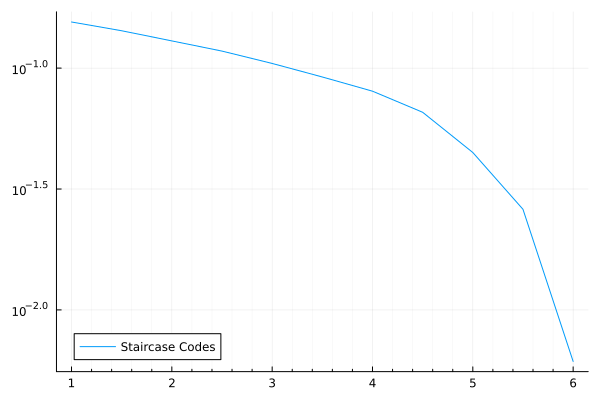

In [19]:
plot(-20 * x_turbo_6, err_turbo_6, minorgrid=:true,
    yaxis=:log, label="Staircase Codes", legend=:bottomleft)